In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import math
import torch.optim as optim
import numpy as np
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import MeanAbsoluteError
from sklearn.preprocessing import StandardScaler
from torchvision.transforms import Resize, ToTensor
from torchvision.transforms.functional import to_pil_image
# from models.resnet import ResNet18VisualEncoder


In [2]:

# Load images function
def load_images(folder):
    images = []
    transform = transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
    ])
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img = Image.open(os.path.join(folder, filename)).convert('RGB')
            img = transform(img)
            images.append(img)
    return torch.stack(images)


In [3]:
# Load data image data
images = load_images('./maze_maps2')

In [4]:
# # Load trajectories data with allow_pickle=True
# data = np.load('trajectories_2.npy', allow_pickle=True)  # Load trajectories data


# # trajectories variable is used for forward_diffusion_process and add_noise
# trajectories = data


# # Display the shape and a few sample data points of the loaded trajectories
# trajectories.shape, trajectories


In [5]:
class SpatialSoftmax(nn.Module):
    def __init__(self):
        super(SpatialSoftmax, self).__init__()

    def forward(self, x):
        # x is of shape [batch_size, channels, height, width]
        # Apply softmax along the spatial dimensions (height and width)
        softmax = torch.nn.functional.softmax(x.view(x.size(0), x.size(1), -1), dim=2)
        return softmax.view(*x.size())

In [6]:

class ResNet18VisualEncoder(nn.Module):
    def __init__(self):
        super(ResNet18VisualEncoder, self).__init__()
        
        # self.resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.resnet18 = resnet18(weights=None)  # Initialize without pre-trained weights
        
        self.resnet18 = nn.Sequential(*list(self.resnet18.children())[:-2])  # Remove the last two layers
        
        # self.softmax_pooling = nn.AdaptiveAvgPool2d((1, 1))  # Add a softmax pooling layer
        # self.softmax_pooling = nn.Softmax()  # Add softmax layer with dim=1
        # self.softmax_pooling = nn.Softmax(dim=1)  # Add softmax layer with dim=1

        self.softmax_pooling = SpatialSoftmax()  # Add spatial softmax pooling

    def forward(self, images):
        features = self.resnet18(images)
        # pooled_features = self.softmax_pooling(features)
        pooled_features = self.softmax_pooling(features)
        # pooled_features = torch.flatten(pooled_features, 1)  # Flatten the features
        return pooled_features


In [7]:
# Instantiate and use the model
encoder = ResNet18VisualEncoder()
encoder.eval()  # Set the model to evaluation mode

ResNet18VisualEncoder(
  (resnet18): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [8]:
with torch.no_grad():  # Disable gradient computation for inference
    latent_embeddings = encoder(images)

In [9]:
# Display the shape of the latent embeddings
print(latent_embeddings.shape)

torch.Size([10, 512, 4, 4])


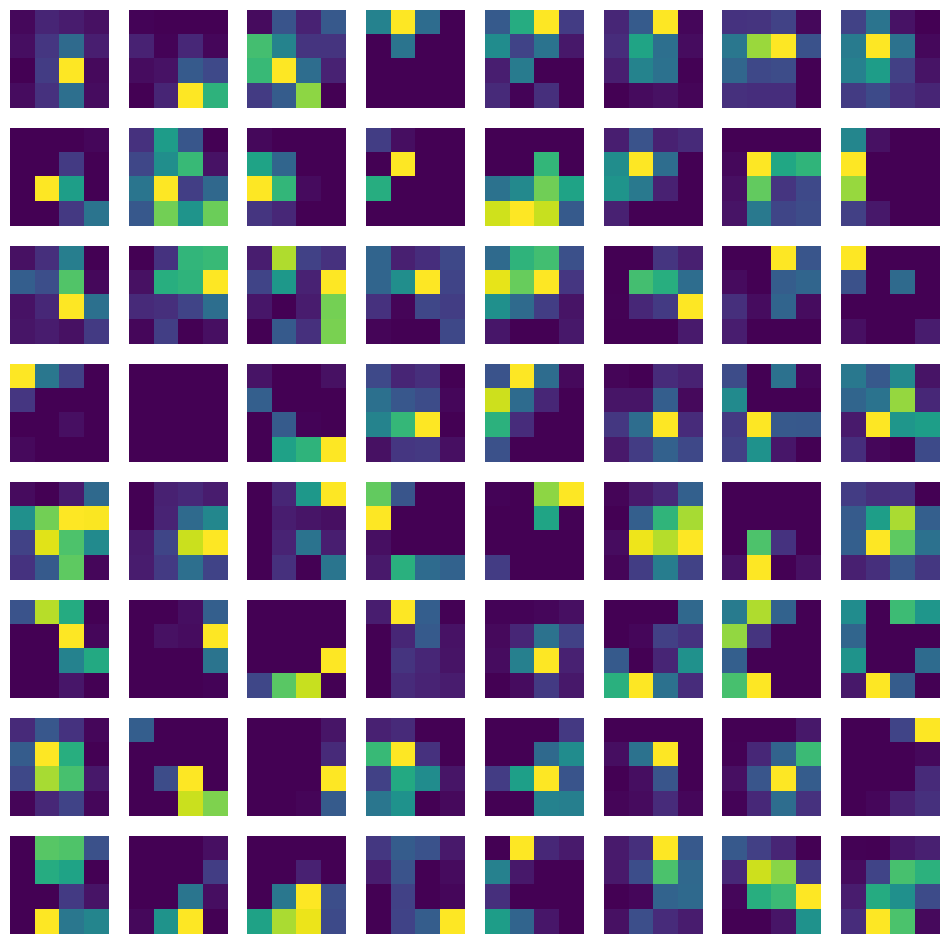

In [10]:
import matplotlib.pyplot as plt

def visualize_feature_maps_subset(feature_maps, num_maps=64):
    batch_size, channels, height, width = feature_maps.shape
    for i in range(batch_size):
        fig, axes = plt.subplots(8, 8, figsize=(12, 12))
        for j in range(num_maps):
            ax = axes[j // 8, j % 8]
            ax.imshow(feature_maps[i, j].detach().cpu().numpy(), cmap='viridis')
            ax.axis('off')
        plt.show()

# Visualize the first sample in the batch
visualize_feature_maps_subset(latent_embeddings[:1])


In [ ]:
import torch.nn.functional as F

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = torch.sigmoid(self.deconv4(x))  # Use sigmoid to get pixel values between 0 and 1
        return x

# Instantiate and use the decoder
decoder = Decoder()
decoder.eval()

with torch.no_grad():
    reconstructed_images = decoder(latent_embeddings)

# Visualize the reconstructed images
def visualize_reconstructed_images(images):
    images = images.permute(0, 2, 3, 1).detach().cpu().numpy()  # Change shape to [batch_size, height, width, channels]
    for img in images:
        
        plt.imshow(img)
        plt.axis('off')
        plt.show()

visualize_reconstructed_images(reconstructed_images)